Implement Bloechl's method of dividing a parallelepiped into equal sized tetrahedra.

Let's make a single parallelepiped and see if we can split it.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.linalg import norm, inv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from BZI.symmetry import make_ptvecs, find_orbitals, point_group
from BZI.plots import PlotMesh
from BZI.sampling import make_cell_points
from itertools import product
from copy import deepcopy
from BZI.pseudopots import Al_PP
from BZI.integration import rectangular_method, rectangular_fermi_level
from BZI.improved_tetrahedron_method import *

In [4]:
center_type = "base"
lat_consts = [1]*3
lat_angles = [np.pi/2]*3
lat_vecs = make_ptvecs(center_type, lat_consts, lat_angles)

In [3]:
indices = []
vertices = []
for k,j,i in product(range(2),repeat=3):
    vertices.append(np.dot(lat_vecs, [i,j,k]))
    indices.append(1 + i + 2*j + 4*k)

In [4]:
vertices

[array([ 0.,  0.,  0.]),
 array([ 0.5, -0.5,  0. ]),
 array([ 0.5,  0.5,  0. ]),
 array([ 1.,  0.,  0.]),
 array([  6.12323400e-17,   6.12323400e-17,   1.00000000e+00]),
 array([ 0.5, -0.5,  1. ]),
 array([ 0.5,  0.5,  1. ]),
 array([  1.00000000e+00,   6.12323400e-17,   1.00000000e+00])]

Still looks good and the indexing is the same as the paper. Next we find the shortest diagonal. Diagonals are 1-8, 2-7, 3-6, 4-5

In [5]:
tetrahedra = find_tetrahedra(vertices)
# diagonal_indices = [[1,8],[2,7],[3,6],[4,5]]
# diagonal_lengths = [norm(vertices[d[1]-1] - vertices[d[0]-1]) for d in
#                     diagonal_indices]
# shared_diagonal = diagonal_indices[np.where(diagonal_lengths == 
#                                            min(diagonal_lengths))[0][0]]

In [6]:
# tet_vertices replaces the indices with the coordinates of the vertices.
tet_vertices = np.empty(np.shape(tetrahedra), dtype=list)
for i,tet in enumerate(tetrahedra):
    for j,t in enumerate(tet):
        tet_vertices[i][j] = vertices[t-1]

In [7]:
lines = []
shift = np.sum(lat_vecs,1)/2
# for shift,tet in zip(shifts,tet_vertices):
for tet in tet_vertices:
    L12 = zip(tet[0], tet[1])
    L14 = zip(tet[0], tet[2])
    L24 = zip(tet[1], tet[2])
    L18 = zip(tet[0], tet[3])
    L28 = zip(tet[1], tet[3])
    L48 = zip(tet[2], tet[3])
    lines += [L12, L14, L24, L18, L28, L48]

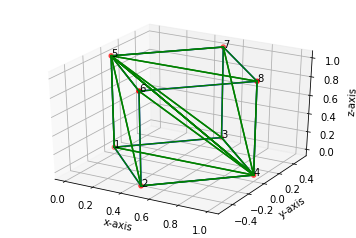

In [8]:
ax = plt.subplot(1,1,1,projection="3d")

offset = [0., 0., 0.]
ngpts = len(vertices)
kxlist = [vertices[i][0] for i in range(ngpts)]
kylist = [vertices[i][1] for i in range(ngpts)]
kzlist = [vertices[i][2] for i in range(ngpts)]

ax.scatter(kxlist, kylist, kzlist, c="red")

# Give the points labels if provided.
if indices:
    for x,y,z,i in zip(kxlist,kylist,kzlist,indices):
        ax.text(x,y,z,i)    
        
c1 = lat_vecs[:,0] 
c2 = lat_vecs[:,1] 
c3 = lat_vecs[:,2] 
O = np.asarray([0.,0.,0.]) 

l1 = zip(O - offset, c1 - offset)
l2 = zip(c2 - offset, c1 + c2 - offset)
l3 = zip(c3 - offset, c1 + c3 - offset)
l4 = zip(c2 + c3 - offset, c1 + c2 + c3 - offset)
l5 = zip(O - offset, c3 - offset)
l6 = zip(c1 - offset, c1 + c3 - offset)
l7 = zip(c2 - offset, c2 + c3 - offset)
l8 = zip(c1 + c2 - offset, c1 + c2 + c3 - offset)
l9 = zip(O - offset, c2 - offset)
l10 = zip(c1 - offset, c1 + c2 - offset)
l11 = zip(c3 - offset, c2 + c3 - offset)
l12 = zip(c1 + c3 - offset, c1 + c2 + c3 - offset)

ls = [l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12]

for l in ls:
    ax.plot3D(*l, c="blue")

for l in lines:
    ax.plot3D(*l, c="green")

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.show()

It appears I was able to successfully divide a tetrahedra. I will need to think of some unit-tests for the division process. The next step is to create a grid and separate it into tetrahedra. I'm going to code the improved tetrahedron method exactly as it is written in the paper.

In [9]:
cell_centering = "prim"
cell_angles = [np.pi/2]*3
cell_consts = [3.]*3
cell_vecs = make_ptvecs(cell_centering, cell_consts, cell_angles)

In [10]:
def blochl_index(i, j, k, ndivisions, offset):
    
    return ((i - offset[0])/2. + (ndivisions[0] + 1)*(
            (j - offset[1])/2. + (ndivisions[1] + 1.)*(
            (k - offset[2])/2.)))*2

In [11]:
# The elements of offset have to either be zeros or ones.
ndiv0 = np.array([3,3,3])
ndiv1 = ndiv0+1
npts = np.prod(ndiv1)
grid = np.empty(ndiv1, dtype=list)
indices = np.empty(ndiv1, dtype=float)
offset = [1,1,1]

for k,j,i in product(range(ndiv1[0]), range(ndiv1[1]), range(ndiv1[2])):
    index = int(i + ndiv1[0]*j + ndiv1[0]*ndiv1[1]*k)
    grid[k,j,i] = np.dot(cell_vecs, np.array([i,j,k])/ndiv0)
    # indices[index] = blochl_index(i,j,k,ndivisions,offset)
    indices[k,j,i] = index
# grid_cellcoords = [np.dot(np.linalg.inv(cell_vecs), g) for g in grid]

I don't see why I have to use Blochl's indexing method. I think it would be easier to simply label the points in the order that they are created 0, 1, 2,... I'm going to try this and if it doesn't work I'll need to come back and fix the indexing.

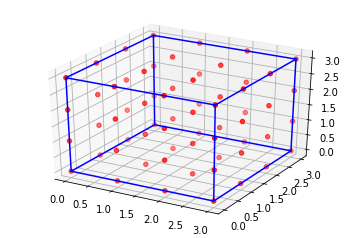

In [12]:
PlotMesh(grid.flatten(), cell_vecs)

I can create the grid with my own indexing. I now need to create the tetrahedra in each submesh cell. The result will be a list of numbers that represent tetrahedra. Afterwards I will find the orbits of the set of k-points and represent each orbit with a single group element.

I need to reshape the grid so that it appears like the points it represents. I'll end one index early in each direction. I will create two lists of indices (this can be changed later). I will find the tetrahedra with the 1-8 indexing and then replace the numbers 1-8 with the actualy k-point indices.

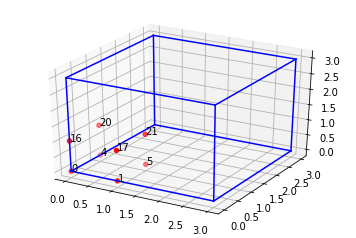

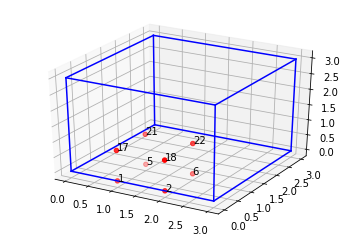

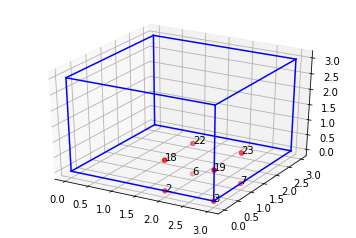

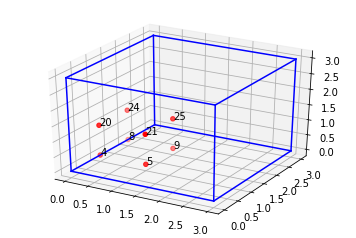

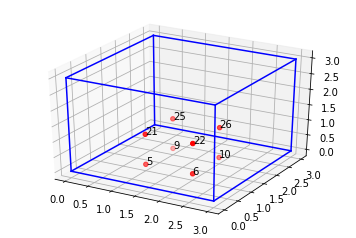

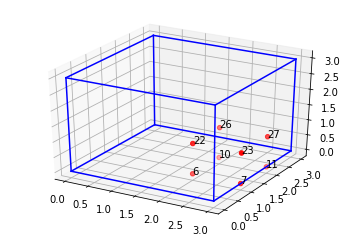

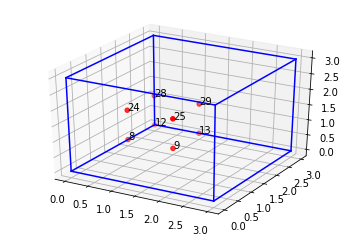

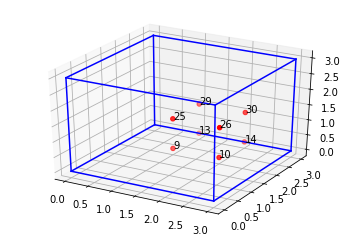

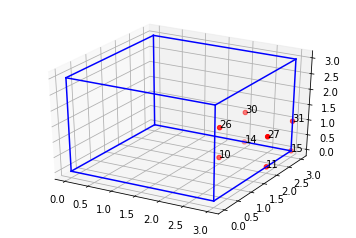

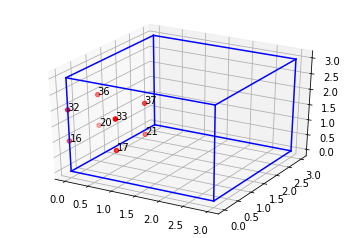

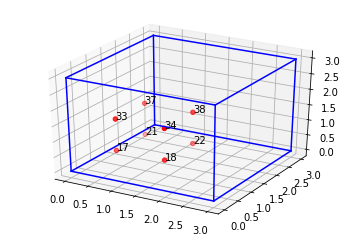

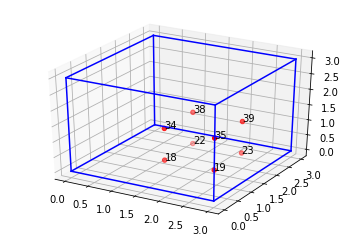

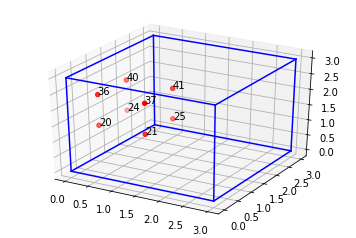

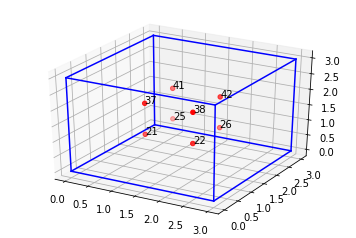

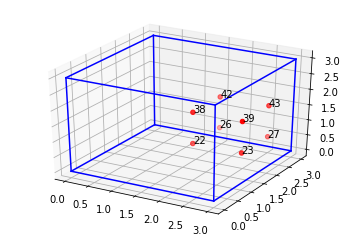

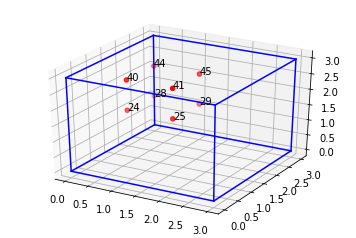

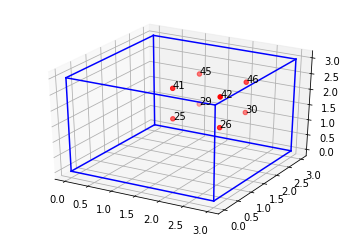

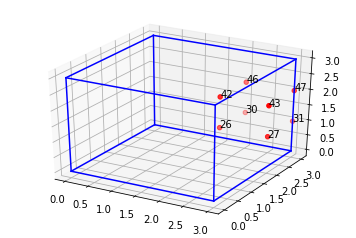

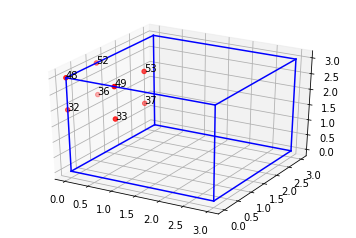

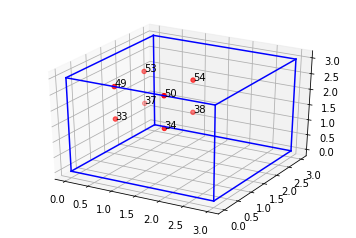

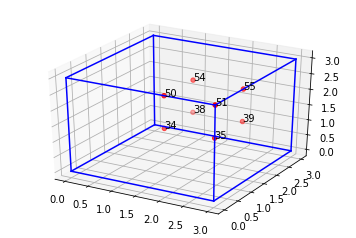

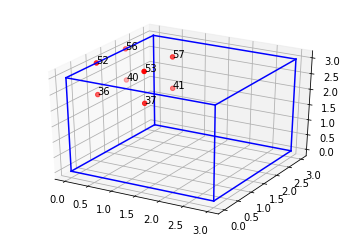

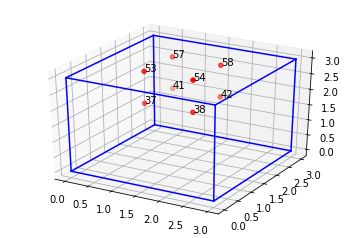

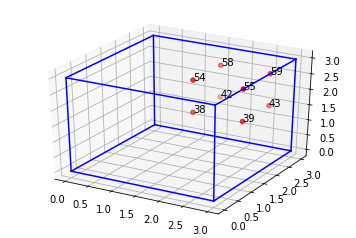

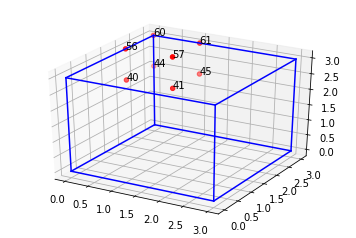

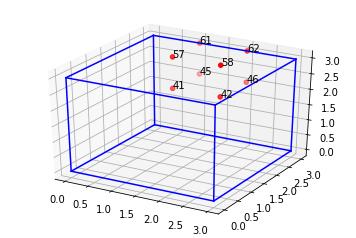

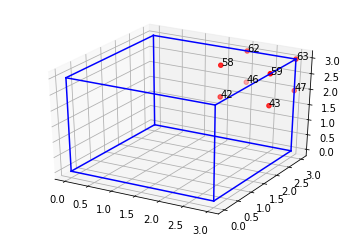

In [15]:
# Let's plot the points to one cube to make sure I select them correctly
for k,j,i in product(range(ndiv0[0]), range(ndiv0[1]), range(ndiv0[2])):
    submesh = np.empty([8], dtype=list)
    submesh_indices = np.empty([8], dtype=int)
    for kk,kj,ki in product(range(2),repeat=3):
        submesh[ki + 2*kj + 4*kk] = grid[k + kk, j + kj, i + ki]
        submesh_indices[ki + 2*kj + 4*kk] = indices[k + kk, j + kj, i + ki]
    PlotMesh(submesh, cell_vecs, [0,0,0], submesh_indices)

Now that I know that I am grabbing the correct points in the correct order, I need to divide each submesh cell into tetrahedra

In [16]:
diagonal_indices = [[1,8],[2,7],[3,6],[4,5]]
tetrahedra = np.empty(np.prod(ndiv0)*6,dtype=list)
for k,j,i in product(range(ndiv0[0]), range(ndiv0[1]), range(ndiv0[2])):
    submesh = np.empty([8], dtype=list)
    submesh_indices = np.empty([8], dtype=int)
    for kk,kj,ki in product(range(2),repeat=3):
        submesh[ki + 2*kj + 4*kk] = grid[k + kk, j + kj, i + ki]
        submesh_indices[ki + 2*kj + 4*kk] = indices[k + kk, j + kj, i + ki]
    
    # Find the tetrahedra with indexing 1-8.
    sub_tetrahedra = find_tetrahedra(submesh)
    
    # Replace 1-8 indices with sub_mesh indices.
    for m in range(6):
        # The index of the submeshcell
        ti = m + 6*(i + ndiv0[0]*j + ndiv0[0]*ndiv0[1]*k)
        tetrahedra[ti] = [0,0,0,0]
        for n in range(4):
            tetrahedra[ti][n] = submesh_indices[sub_tetrahedra[m][n]-1]

Let's make sure that the tetrahedra are unique

In [17]:
for i in range(len(tetrahedra)):
    for j in np.delete(range(len(tetrahedra)),i):
        if np.allclose(tetrahedra[i], tetrahedra[j]):
            print("same")

Now I need to find the irreducible tetrahedra. I'll need to find the orbits of the k-points. I can find the orbits of the k-points with find_orbitals

In [ ]:
orbitals = find_orbitals(grid.flatten(), cell_vecs)

Create a new dictionary where the keys are the indices of the grid and the values are the index of the representative element of each k-point orbital.

In [213]:
new_dict = {}
for key in orbitals.keys():
    pt = orbitals[key][0]
    value = np.where([np.allclose(gpt,pt) for gpt in grid.flatten()])[0][0]
    for val in orbitals[key]:
        index = np.where([np.allclose(pt,val) for pt in grid.flatten()])[0][0]
        new_dict[index] = value

The tetrahedra are represented by 4 indices. These are the indices of the points in the grid. Replace these indices by the representative index.

In [236]:
irr_tet_weights = []
irreducible_tetrahedra = []
for i,tet in enumerate(tetrahedra):
    for j,ind in enumerate(tet):
        tetrahedra[i][j] = new_dict[ind]
    if any([np.allclose(tetrahedra[i],tet) for tet in irreducible_tetrahedra]):
        loc = np.where([np.allclose(tetrahedra[i],tet) for tet in irreducible_tetrahedra])[0][0]
        irr_tet_weights[loc] += 1
        continue
    else:
        irreducible_tetrahedra.append(tetrahedra[i])
        irr_tet_weights.append(1.)

I'm going to write the functions for determining the contribution of a single tetrahedron to the number of states and possibly the density of states. I'll also calculate the integration weights of each tetrahedron.

Let's make a small unit test for number of states.

## Improved tetrahedron method with Al pseudopotential

I'm going to find the Fermi level and integrate without symmetry reduction at first just to make sure things are correct up to this point.

Let's get an estimate of what the Fermi level and total energy should be for the Al pseudopotential.

In [5]:
grid, tetrahedra = grid_and_tetrahedra(Al_PP, [10]*3, [0,0,0])
fermi_level = rectangular_fermi_level(Al_PP, grid.flatten(), 10)
total_energy = rectangular_method(Al_PP, 5, grid.flatten(), 
                                  Al_PP.lattice.reciprocal_vectors,
                                  fermi_level)

In [40]:
fermi_level

11.778759391892553

In [41]:
total_energy

21.752305414942978

In [20]:
def calc_total_states(PP, tetrahedra, weights, grid, energy, nbands):
    """Calculate the total number of filled states.
    
    Args:
        PP (:py:obj:`BZI.pseudopots.EmpiricalPP`): a pseudopotential object.
        grid (numpy.ndarray): a grid of points in 3D.
        tetrahedra (numpy.ndarray): lists of tetrahedra vertices.
        weights (list or numpy.ndarray): a list of tetrahedron weights.
        grid (numpy.ndarray): a grid of points in 3D.
        tol (float): the tolerance on the total number of states.    
        energy (float): the energy at which the total number of states is being
            calculated.
            
    Returns:
        total_states (float): the number of filled states.
    """
    
    Vg = PP.lattice.volume
    
    nsubcells = np.prod(np.array(np.shape(grid)) - 1)
    Vt = Vg/(6*nsubcells) # fix this
    
    total_states = 0.
    for i,tet in enumerate(tetrahedra):
        energies = []
        for ind in tet:
            energies.append(PP.eval(grid.flatten()[ind], nbands))
        # Reshape energies so that the energies of each band are grouped together and
        # are sorted from least to greatest.
        energies = np.transpose(energies)
        for en in energies:
            total_states += (weights[i]*
                             number_of_states(Vg, Vt, np.sort(en), energy))
    return total_states

def find_fermi_level(PP, tetrahedra, weights, grid, tol=1e-3):
    """Determine the Fermi level for a given pseudopotential using the 
    improved tetrahedron method.
    
    Args:
        PP (:py:obj:`BZI.pseudopots.EmpiricalPP`): a pseudopotential object.
        tetrahedra (numpy.ndarray): lists of tetrahedra vertices.
        weights (list or numpy.ndarray): a list of tetrahedron weights. These
            should all be one if the tetrahedra are left unreduced.
        grid (numpy.ndarray): a grid of points in 3D.
        tol (float): the tolerance on the total number of states.
        
    Returns:
        fermi_level (float): the fermi level to within the prodived tolerance
            on the total number of states.
    """
    
    # Gives the sign of a number (+/-) unless it is zero, in which case it
    # returns zero.
    sign = lambda x: x and (1, -1)[x<0]
    
    nfs = PP.nvalence_electrons/2. # number of filled states
    hfb = int(np.ceil(nfs)) # highest filled band
    nbands = hfb + 10
    if hfb < 2:
        fermi_level = PP.eval([0.]*3, nbands)[hfb]
    else:
        fermi_level = (PP.eval([0.]*3, nbands)[hfb] - 
                             PP.eval([0.]*3, nbands)[hfb-2])/2    
        
    total_states = calc_total_states(PP, tetrahedra, weights, grid, 
                                     fermi_level, nbands)
    initial_sign = sign(total_states - nfs)
    
    # We first need to find a window in which the Fermi level resides.
    # We do this by increasing or decreasing the estimated fermi level until
    # we have too many/not enough filled states.
    while sign(total_states - nfs) == initial_sign:
        fermi_level = fermi_level + (
                            sign(PP.nvalence_electrons/2 - total_states))*4
        total_states = calc_total_states(PP, tetrahedra, weights, grid,
                                        fermi_level, nbands)

    if total_states > nfs:
        lower_bound = fermi_level - 4
        upper_bound = fermi_level
        fermi_level -= (upper_bound - lower_bound)/2
    else:
        lower_bound = fermi_level
        upper_bound = fermi_level + 4
        fermi_level += (upper_bound - lower_bound)/2    

    # Now we can do something like a binary search.
    while abs(total_states - nfs) > tol:
        total_states = calc_total_states(PP, tetrahedra, weights, grid,
                                         fermi_level, nbands)
        if total_states > nfs:
            upper_bound = fermi_level
            fermi_level -= (upper_bound - lower_bound)/2.
        else:
            lower_bound = fermi_level
            fermi_level += (upper_bound - lower_bound)/2.
            
    return fermi_level

In [21]:
grid_sizes = [2,3,4,5,6]
fermi_levels = []

for s in grid_sizes:
    ndiv0 = np.array([s,s,s])
    ndiv1 = ndiv0 + 1
    offset = [0]*3
    grid, tetrahedra = grid_and_tetrahedra(Al_PP, ndiv0, offset)
    weights = np.ones(len(tetrahedra))
    fermi_levels.append(find_fermi_level(Al_PP, tetrahedra, weights, grid))

first loop
fermi level:  9.71602980107
total states:  1.61705180572
first loop
fermi level:  5.71602980107
total states:  0.29877886597
second loop
fermi level:  7.71602980107
total states:  0.853540912326
second loop
fermi level:  8.71602980107
total states:  1.4572316036
second loop
fermi level:  9.21602980107
total states:  1.58309029704
second loop
fermi level:  8.96602980107
total states:  1.54690408744
second loop
fermi level:  8.84102980107
total states:  1.50764632279
second loop
fermi level:  8.77852980107
total states:  1.4837133907
second loop
fermi level:  8.80977980107
total states:  1.49599993881
second loop
fermi level:  8.82540480107
total states:  1.50190602272
second loop
fermi level:  8.81759230107
total states:  1.49897334103
second loop
fermi level:  8.82149855107
total states:  1.50044481728
first loop
fermi level:  9.71602980107
total states:  1.0
second loop
fermi level:  11.7160298011
total states:  1.27823807018
second loop
fermi level:  12.7160298011
total st

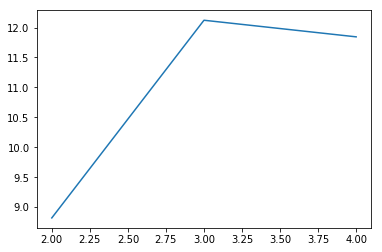

In [22]:
plt.plot(grid_sizes, fermi_levels)
plt.show()

It's pretty slow, probably another motivation for reducing the tetrahedra. The reduced version is below.

It appears that the Fermi level as calculated by Blochl's method, gets smaller and closer to what I would expect the Fermi level to be, but it's still much larger than the value calculated by the rectangle method, which is even close to the expected Fermi level. I'll need to look to find where the bug might be. It possible that Blochl's method converges slower than the rectangle method but that is counter intuitive.

In [36]:
def find_irreducible_tetrahedra(PP, tetrahedra, grid):
    """Find the irreducible tetrahedra and their weights.
    
    Args:
        PP (:py:obj:`BZI.pseudopots.EmpiricalPP`): a pseudopotential object.
        tetrahedra (numpy.ndarray): lists of tetrahedra vertices.
        grid (numpy.ndarray): a grid of points in 3D.
    Returns:
        irreducible_tetrahedra (list): a list of irreducible tetrahedra vertices.
        weights (list): a list of tetrahedron weights.
    """
    
    orbitals = find_orbitals(grid.flatten(), PP.lattice.reciprocal_vectors)
    
    # Each point in the grid is part of an orbit. One point at randome is chosen 
    # to represent each orbit. The dictionary new_dict is a dictionary with keys
    # as the indices of the grid points and values the index of the point that 
    # represents its orbit.
    new_dict = {}
    for key in orbitals.keys():
        pt = orbitals[key][0]
        value = np.where([np.allclose(gpt,pt) for gpt in grid.flatten()])[0][0]
        for val in orbitals[key]:
            index = np.where([np.allclose(pt,val) for pt in grid.flatten()])[0][0]
            new_dict[index] = value
            
    weights = []
    irreducible_tetrahedra = []
    for i,tet in enumerate(tetrahedra):
        for j,ind in enumerate(tet):
            # Replace the indices in tetrahedra with the one that represents its orbit.
            tetrahedra[i][j] = new_dict[ind]
        # Sort the indices so they can be easily compared.
        tetrahedra[i] = np.sort(tetrahedra[i])
        # If the tetrahedra being considered is alread apart of the list of 
        # irreducible tetrahedra, at 1 to its weight.
        if any([np.allclose(tetrahedra[i],tet) for tet in irreducible_tetrahedra]):
            loc = np.where([np.allclose(tetrahedra[i],tet) for tet in irreducible_tetrahedra])[0][0]
            weights[loc] += 1.
            continue
        # If not add it to the list and give it weight 1.
        else:
            irreducible_tetrahedra.append(tetrahedra[i])
            weights.append(1.)
    return irreducible_tetrahedra, weights

In [41]:
ndiv0 = np.array([4,4,4])
ndiv1 = ndiv0 + 1
offset = [0]*3
grid, tetrahedra = grid_and_tetrahedra(Al_PP, ndiv0, offset)
irreducible_tetrahedra, weights = find_irreducible_tetrahedra(Al_PP, tetrahedra, grid)
fermi_level = find_fermi_level(Al_PP, irreducible_tetrahedra, weights, grid)

125
first loop
fermi level:  9.71602980107
total states:  1.01834475972
second loop
fermi level:  11.7160298011
total states:  1.22343003669
second loop
fermi level:  12.7160298011
total states:  1.39544722736
second loop
fermi level:  13.2160298011
total states:  1.48122375783
second loop
fermi level:  13.4660298011
total states:  1.52197243937
second loop
fermi level:  13.3410298011
total states:  1.50183834865
second loop
fermi level:  13.2785298011
total states:  1.4915864694
second loop
fermi level:  13.3097798011
total states:  1.49672684386
second loop
fermi level:  13.3254048011
total states:  1.49928627756


In [42]:
fermi_level

13.33321730107153

In [43]:
weights = np.ones(len(tetrahedra))
find_fermi_level(Al_PP, tetrahedra, weights, grid)

first loop
fermi level:  9.71602980107
total states:  1.01834475972
second loop
fermi level:  11.7160298011
total states:  1.22343003669
second loop
fermi level:  12.7160298011
total states:  1.39544722736
second loop
fermi level:  13.2160298011
total states:  1.48122375783
second loop
fermi level:  13.4660298011
total states:  1.52197243937
second loop
fermi level:  13.3410298011
total states:  1.50183834865
second loop
fermi level:  13.2785298011
total states:  1.4915864694
second loop
fermi level:  13.3097798011
total states:  1.49672684386
second loop
fermi level:  13.3254048011
total states:  1.49928627756


13.33321730107153

In [21]:
tol = 1e-1
sign = lambda x: x and (1, -1)[x<0]
initial_sign = sign(total_states - Al_PP.nvalence_electrons/2)

# We first need to find a window in which the Fermi level resides.
while sign(total_states - Al_PP.nvalence_electrons/2) == initial_sign:
    fermi_level_guess = fermi_level_guess + (
                        sign(Al_PP.nvalence_electrons/2 - total_states))*4
    total_states = calc_total_states(Al_PP, irreducible_tetrahedra, 
                                    fermi_level_guess)
    
if total_states > Al_PP.nvalence_electrons/2:
    lower_bound = fermi_level_guess - 4
    upper_bound = fermi_level_guess
    fermi_level_guess -= (upper_bound - lower_bound)/2
else:
    lower_bound = fermi_level_guess
    upper_bound = fermi_level_guess + 4
    fermi_level_guess += (upper_bound - lower_bound)/2    

# Now we can do something like a binary search.
while abs(total_states - Al_PP.nvalence_electrons/2) > tol:
    total_states = calc_total_states(Al_PP, irreducible_tetrahedra,
                                     fermi_level_guess)
    
    if total_states > Al_PP.nvalence_electrons/2:
        upper_bound = fermi_level_guess
        fermi_level_guess -= (upper_bound - lower_bound)/2.
    else:
        lower_bound = fermi_level_guess
        fermi_level_guess += (upper_bound - lower_bound)/2.

NameError: name 'irreducible_tetrahedra' is not defined

Symmetry reduction starts here.

In [23]:
orbitals = find_orbitals(grid.flatten(), Al_PP.lattice.reciprocal_vectors)
new_dict = {}
for key in orbitals.keys():
    pt = orbitals[key][0]
    value = np.where([np.allclose(gpt,pt) for gpt in grid.flatten()])[0][0]
    for val in orbitals[key]:
        index = np.where([np.allclose(pt,val) for pt in grid.flatten()])[0][0]
        new_dict[index] = value

In [24]:
new_dict

{0: 124,
 1: 123,
 2: 122,
 3: 123,
 4: 124,
 5: 123,
 6: 118,
 7: 117,
 8: 118,
 9: 123,
 10: 122,
 11: 117,
 12: 112,
 13: 117,
 14: 122,
 15: 123,
 16: 118,
 17: 117,
 18: 118,
 19: 123,
 20: 124,
 21: 123,
 22: 122,
 23: 123,
 24: 24,
 25: 123,
 26: 118,
 27: 117,
 28: 118,
 29: 123,
 30: 118,
 31: 93,
 32: 92,
 33: 93,
 34: 118,
 35: 117,
 36: 92,
 37: 87,
 38: 92,
 39: 117,
 40: 118,
 41: 93,
 42: 92,
 43: 93,
 44: 118,
 45: 123,
 46: 118,
 47: 117,
 48: 118,
 49: 49,
 50: 122,
 51: 117,
 52: 112,
 53: 117,
 54: 122,
 55: 117,
 56: 92,
 57: 87,
 58: 92,
 59: 117,
 60: 112,
 61: 87,
 62: 62,
 63: 87,
 64: 112,
 65: 117,
 66: 92,
 67: 87,
 68: 92,
 69: 117,
 70: 122,
 71: 117,
 72: 112,
 73: 117,
 74: 74,
 75: 123,
 76: 118,
 77: 117,
 78: 118,
 79: 123,
 80: 118,
 81: 93,
 82: 92,
 83: 93,
 84: 118,
 85: 117,
 86: 92,
 87: 87,
 88: 92,
 89: 117,
 90: 118,
 91: 93,
 92: 92,
 93: 93,
 94: 118,
 95: 123,
 96: 118,
 97: 117,
 98: 118,
 99: 99,
 100: 124,
 101: 123,
 102: 122,
 103: 12

In [6]:
irr_tet_weights = []
irreducible_tetrahedra = []
for i,tet in enumerate(tetrahedra):
    for j,ind in enumerate(tet):
        tetrahedra[i][j] = new_dict[ind]
    tetrahedra[i] = np.sort(tetrahedra[i])
    if any([np.allclose(tetrahedra[i],tet) for tet in irreducible_tetrahedra]):
        loc = np.where([np.allclose(tetrahedra[i],tet) for tet in irreducible_tetrahedra])[0][0]
        irr_tet_weights[loc] += 1
        continue
    else:
        irreducible_tetrahedra.append(tetrahedra[i])
        irr_tet_weights.append(1.)

Now that I have the irreducible tetrahedra for Al, I just need to generate the eigenvalues at the corners of the tetrahedra.

In [8]:
def calc_total_states(PP, tetrahedra, weights, grid, fermi_level_guess):
    """Calculate the total number of filled states.
    """
    
    Vg = Al_PP.lattice.volume
    Vt = Vg/(6*np.prod(np.shape(grid)))
    
    total_states = 0.
    for i,irr_tet in enumerate(tetrahedra):
        energies = []
        for ind in irr_tet:
            energies.append(Al_PP.eval(grid.flatten()[ind], 5))
        # Reshape energies so that the energies of each band are grouped together.
        energies = np.transpose(energies)
        print(energies)
        print(np.sort(energies))
        for en in energies:
            total_states += (weights[i]*
                             number_of_states(Vg, Vt, np.sort(en), fermi_level_guess))
    return total_states

In [9]:
tol = 1e-4

# sign gives the sign of a number, unless zero, in which case it gives zero.
sign = lambda x: x and (1, -1)[x<0]

nfs = Al_PP.nvalence_electrons/2. # number of filled states
hfb = int(np.ceil(nfs)) # highest filled band
nbands = hfb + 2
if hfb < 2:
    fermi_level_guess = Al_PP.eval([0.]*3, nbands)[hfb]
else:    
    fermi_level_guess = (Al_PP.eval([0.]*3, nbands)[hfb] - 
                         Al_PP.eval([0.]*3, nbands)[hfb-2])/2

total_states = calc_total_states(Al_PP, irreducible_tetrahedra,
                                 fermi_level_guess)

In [10]:
initial_sign = sign(total_states - Al_PP.nvalence_electrons/2)

# We first need to find a window in which the Fermi level resides.
while sign(total_states - Al_PP.nvalence_electrons/2) == initial_sign:
    fermi_level_guess = fermi_level_guess + (
                        sign(Al_PP.nvalence_electrons/2 - total_states))*4
    total_states = calc_total_states(Al_PP, irreducible_tetrahedra, 
                                    fermi_level_guess)
    
if total_states > Al_PP.nvalence_electrons/2:
    lower_bound = fermi_level_guess - 4
    upper_bound = fermi_level_guess
    fermi_level_guess -= (upper_bound - lower_bound)/2
else:
    lower_bound = fermi_level_guess
    upper_bound = fermi_level_guess + 4
    fermi_level_guess += (upper_bound - lower_bound)/2    

# Now we can do something like a binary search.
while abs(total_states - Al_PP.nvalence_electrons/2) > tol:
    total_states = calc_total_states(Al_PP, irreducible_tetrahedra,
                                     fermi_level_guess)
    
    if total_states > Al_PP.nvalence_electrons/2:
        upper_bound = fermi_level_guess
        fermi_level_guess -= (upper_bound - lower_bound)/2.
    else:
        lower_bound = fermi_level_guess
        fermi_level_guess += (upper_bound - lower_bound)/2.

In [11]:
fermi_level_guess

22.866908707321528

Next calculate the total energy.

In [12]:
def calc_total_energy(PP, tetrahedra, weights, fermi_level, nbands):
    """Calculate the total energy.
    
    Args:
        PP (:py:obj:`BZI.pseudopots.EmpiricalPP`): a pseudopotential object.
        tetrahedra (numpy.ndarray): lists of tetrahedra vertices.
        weights (list or numpy.ndarray): a list of tetrahedron weights.
        grid (numpy.ndarray): a grid of points in 3D.
        fermi_level (float): the energy at which the total energy is being 
            calculated.
            
    Returns:
        total_states (float): the number of filled states.
    
    """

    Vg = Al_PP.lattice.volume
    nsubcells = np.prod(np.array(np.shape(grid)) - 1)
    Vt = Vg/(6*nsubcells)
    
    total_energy = 0.
    for i,irr_tet in enumerate(tetrahedra):
        energies = []
        for ind in irr_tet:
            energies.append(Al_PP.eval(grid.flatten()[ind], nbands))
        # Reshape energies so that the energies of each band are group together.
        energies = np.sort(np.transpose(energies))

        for en in energies:
            weights = integration_weights(Vg, Vt, en, fermi_level)
            total_energy += weights[i]*np.dot(weights, en)
            
    return total_energy

In [13]:
total_energy = calc_total_energy(Al_PP, irreducible_tetrahedra, irr_tet_weights, 
                                 fermi_level_guess)

In [14]:
total_energy

19.427527981195446

In [15]:
rec_toten = rectangular_method(Al_PP, 5, grid.flatten(), Al_PP.lattice.reciprocal_vectors,
                               fermi_level_guess)

In [16]:
rec_toten

85.884927716258773

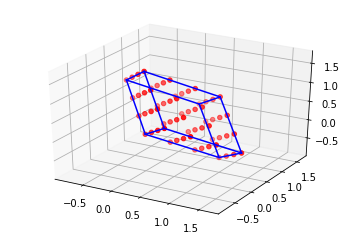

In [37]:
PlotMesh(grid.flatten(),Al_PP.lattice.reciprocal_vectors)

In [ ]:
grid_sizes = [2,3,4,5,6]
fermi_levels = []

for s in grid_sizes:
    ndiv0 = np.array([s,s,s])
    ndiv1 = ndiv0 + 1
    offset = [0]*3
    grid, tetrahedra = grid_and_tetrahedra(Al_PP, ndiv0, offset)
    weights = np.ones(len(tetrahedra))
    fermi_levels.append(find_fermi_level(Al_PP, tetrahedra, weights, grid))

# New tests start here

In [3]:
ndiv0 = np.array([3,3,3])
ndiv1 = ndiv0 + 1
offset = [0]*3
nbands = int(np.ceil(Al_PP.nvalence_electrons/2) + 5)
print(nbands)
grid, tetrahedra = grid_and_tetrahedra(Al_PP, ndiv0, offset)

7


In [4]:
orbitals = find_orbitals(grid.flatten(), Al_PP.lattice.reciprocal_vectors)

In [5]:
find_irreducible_tetrahedra(Al_PP, tetrahedra, grid)

{15: 15, 0: 15, 2: 2, 21: 2, 1: 2, 42: 2, 3: 3, 11: 11, 10: 10, 5: 10, 17: 10, 34: 10, 9: 9, 26: 9, 37: 9, 38: 9, 25: 9, 36: 9, 6: 9, 18: 9, 41: 9, 33: 9, 22: 9, 7: 7, 12: 12, 13: 13, 47: 47, 35: 35, 43: 43, 39: 39, 44: 44, 45: 45, 31: 31, 19: 19, 27: 27, 23: 23, 28: 28, 30: 30, 63: 63, 50: 50, 49: 49, 51: 51, 59: 59, 58: 58, 57: 57, 55: 55, 54: 54, 53: 53, 14: 14}


KeyError: 4

In [82]:
a = np.array([[]])
b = np.array([[4,5,6]])
np.concatenate((a,b),1)

array([[ 4.,  5.,  6.]])

In [103]:
import time
grid_car = grid.flatten()
lat_vecs = Al_PP.lattice.reciprocal_vectors
duplicates = True

In [121]:
# Put the grid in lattice coordinates.

grid_cell = np.array([np.dot(np.linalg.inv(lat_vecs), gc) for gc in grid_car])%1

# Remove duplicates if necessary.    
t1 = time.time()
if duplicates:
    grid_copy = list(deepcopy(grid_cell))
    grid_cell2 = []
    while len(grid_copy) != 0:
        gp = grid_copy.pop()
        if any([np.allclose(gp, gc) for gc in grid_copy]):
            continue
        else:
            grid_cell2.append(gp)
t2 = time.time()
print(t2 - t1)

0.06067824363708496


In [1]:
import numpy as np
from numpy.linalg import inv
from BZI.symmetry import make_ptvecs, point_group, find_orbitals
import copy

In [126]:
lat_angles = [np.pi/2]*3
lat_consts = [1]*3
lat_centering = "face"
lat_vecs = make_ptvecs(lat_centering, lat_consts, lat_angles)

In [127]:
grid = [[0,.5,.5], [.5,.5,0], [.5,0,.5], 
        [0,-.5,.5], [-.5,.5,0], [-.5,0,.5], 
        [0,.5,-.5], [.5,-.5,0], [.5,0,-.5], 
        [0,-.5,-.5], [-.5,-.5,0], [-.5,0,-.5]]

In [20]:
o = find_orbitals(grid, lat_vecs)

In [23]:
from BZI.sampling import make_cell_points

In [27]:
grid_centering = "face"
grid_consts = [.5,.5,.5]
grid_angles = [np.pi/2]*3
grid_vecs = make_ptvecs(grid_centering, grid_consts, grid_angles)
grid = make_cell_points(lat_vecs, grid_vecs)

All the points at constant radius should be in the same orbital. Let's build the orbitals
by grouping points together with the same radius.

In [58]:
orbitals = {}
for g in grid:
    key = np.round(norm(g), 6)
    if key in orbitals:
        orbitals[key].append(g)
    else:
        orbitals[key] = [g]
        
# orb_keys = orbitals.keys()
# for i,k in enumerate(orbitals.keys()):
#     print(k)
#     print(orbitals)
#     orbitals[i+1] = orbitals.pop(k)
#     print("orb")
#     print(orbitals)

In [74]:
gtmp

array([[ 0. ,  0. ,  0. ],
       [ 0. , -0. ,  0.5],
       [ 0. ,  0.5, -0. ],
       [ 0. ,  0.5,  0.5],
       [ 0.5,  0. ,  0. ],
       [ 0.5, -0. ,  0.5],
       [ 0.5,  0.5, -0. ],
       [ 0.5,  0.5,  0.5]])

<IPython.core.display.Javascript object>


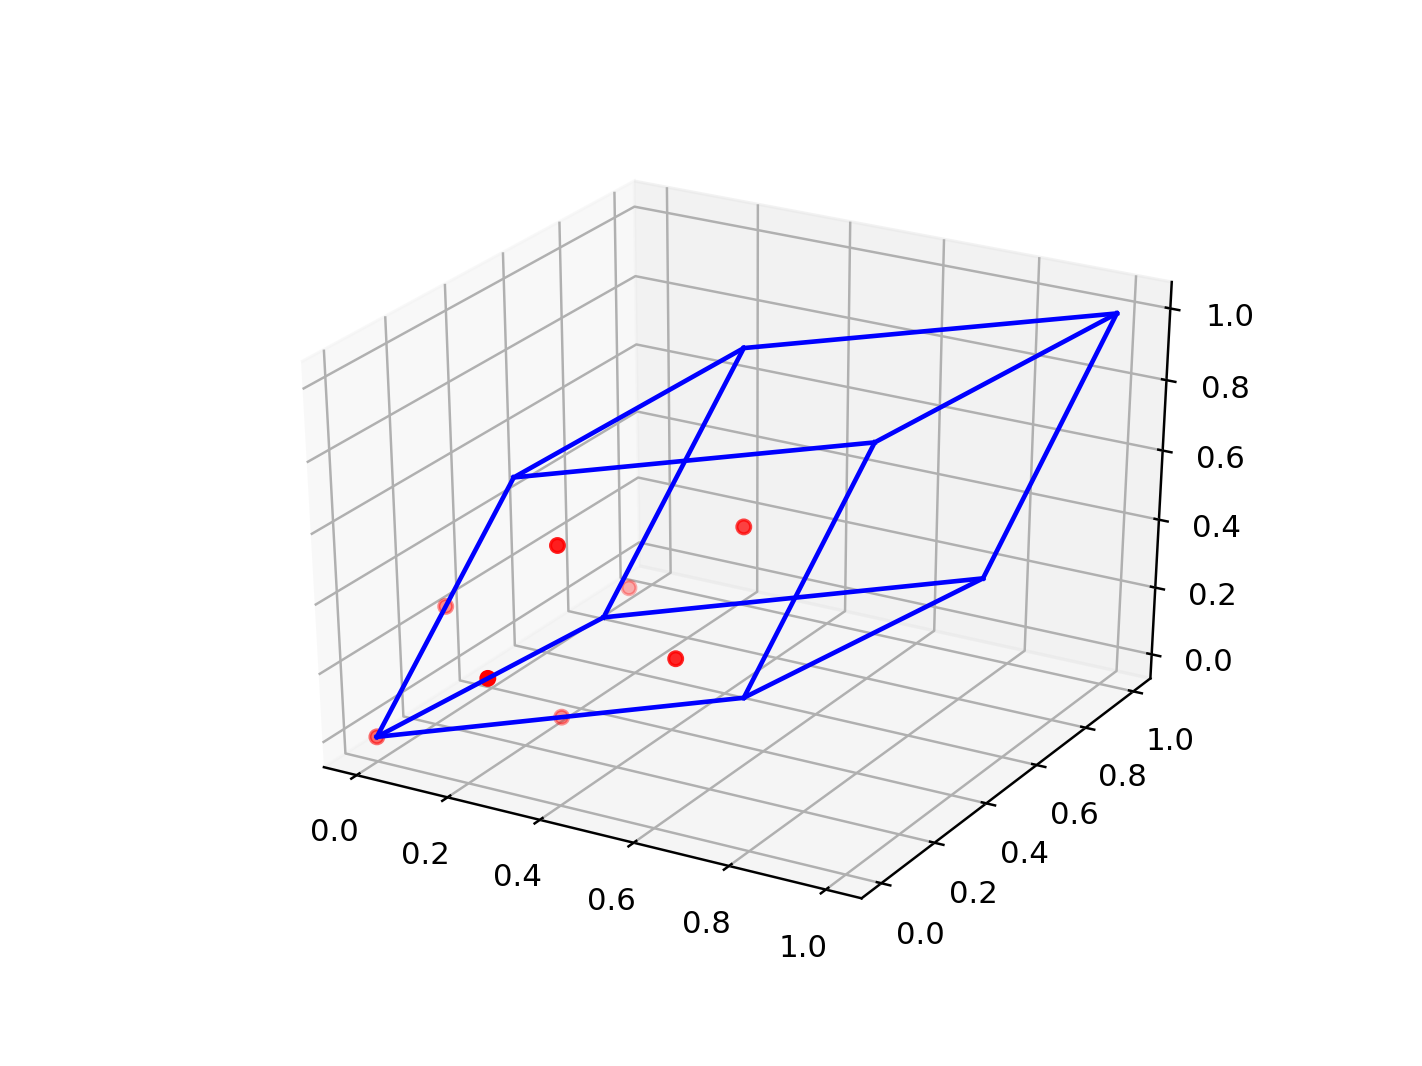

In [75]:
PlotMesh(grid, lat_vecs)